Efficiency Toy
====

Example of the efficiency correction procedure using multiple distributions

In [2]:
# Just some boilerplate code
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib import rcParams

rcParams["figure.figsize"] = (10.0, 8.0)

rng = np.random.default_rng()
pdf_domain = (-3, 7)
pdf_range = (0, 1.0)


def sample(N, pdf):
    """
    Use accept-reject sampling to get N samples from pdf
    
    slow
    """
    
    points = np.zeros(N)
    num_generated = 0
    
    with tqdm(total=N) as pbar:
        while num_generated < N:
            # Generate a point
            x = pdf_domain[0] + (pdf_domain[1] - pdf_domain[0]) * rng.random()
            y = pdf_range[0] + (pdf_range[1] - pdf_range[0]) * rng.random()

            if y < pdf(x):
                points[num_generated] = x
                num_generated += 1
                pbar.update(1)

    return points

We have three different distributions - call them WS, RS ("wrong/right sign") and phsp.
We can generate these from the models ("model sample") or via LHCb Monte Carlo ("MC sample").

The MC samples are affected by the efficiency- by comparing the MC sample to the model samples
We can extract the efficiency function $\epsilon(x)$.

We have three models; their PDFs are $\mathcal{A}_{RS}(x)$, $\mathcal{A}_{WS}(x)$ and $\mathcal{A}_{phsp}(x)$.
The corresponding PDFs describing the MC are $\mathcal{A}_{RS}(x)\epsilon(x)$, etc.

We can describe the combined signal samples with the following PDF:
$p_{model}(x) = \mathcal{I}_{RS}\mathcal{A}_{RS}(x) + \mathcal{I}_{WS}\mathcal{A}_{WS}(x)$, where the $\mathcal{I}$ coefficients are found from:

$\mathcal{I}_{j} = \sum_{x_i \epsilon \{x_j\}}1/p_j(x_i)$  
i.e.; the WS coefficient is found from the sum of the inverse WS probabilities over the WS dataset.

The PDF describing the combined RS + WS + phsp model samples is then:

$p(x) = \mathcal{I}_{model}p_{model}(x) + \mathcal{I}_{phsp}\mathcal{A}_{phsp}(x)$

the PDF describing the combined MC samples is this multiplied by $\epsilon(x)$.

Below is a toy example of the procedure used to find the efficiency.

First we need to generate MC samples:

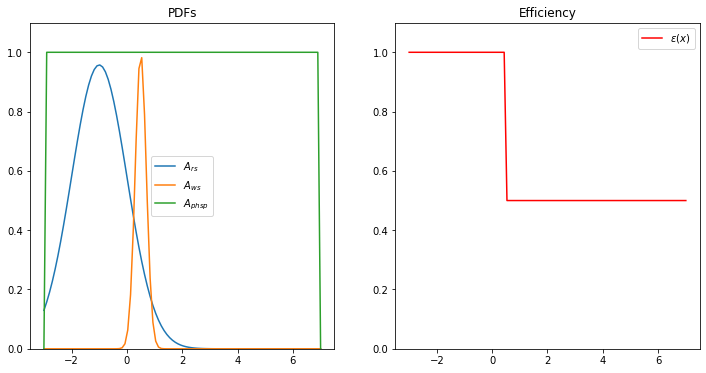

In [3]:
# Model "PDFs" - not normalised (on purpose, since in reality amplitude models are rarely normalised)
def A_rs(x):
    return 2.4 * norm.pdf(x, loc=-1.0, scale=1)

def A_ws(x):
    return 0.5 * norm.pdf(x, loc=0.5, scale=0.2)

def A_phsp(x):
    return int(pdf_domain[0] < x < pdf_domain[1])

def e(x):
    if x < 0.5:
        return 1
    return 0.5

x = np.linspace(*pdf_domain, 100)
fig, ax = plt.subplots(1, 2, figsize=(12.0, 6.0))
ax[0].plot(x, [A_rs(i) for i in x], label=r"$A_{rs}$")
ax[0].plot(x, [A_ws(i) for i in x], label=r"$A_{ws}$")
ax[0].plot(x, [A_phsp(i) for i in x], label=r"$A_{phsp}$")
ax[0].set_ylim((0.0, 1.1))
ax[0].legend()
ax[0].set_title("PDFs")

ax[1].plot(x, [e(i) for i in x], label="$\epsilon(x)$", color="r")
ax[1].legend()
ax[1].set_ylim((0.0, 1.1))
ax[1].set_title("Efficiency")

plt.show()


In [24]:
# Generate different numbers of points from each distribution 
N_rs, N_ws, N_phsp, N_model = 5000, 2000, 2000, 4000

mc_rs_sample = sample(N_rs, lambda x: A_rs(x) * e(x))
mc_ws_sample = sample(N_ws, lambda x: A_ws(x) * e(x))
mc_phsp_sample = sample(N_phsp, lambda x: A_phsp(x) * e(x))

mc_sample = np.concatenate((mc_rs_sample, mc_ws_sample, mc_phsp_sample))

100%|██████████| 2000/2000 [00:00<00:00, 317930.95it/s]


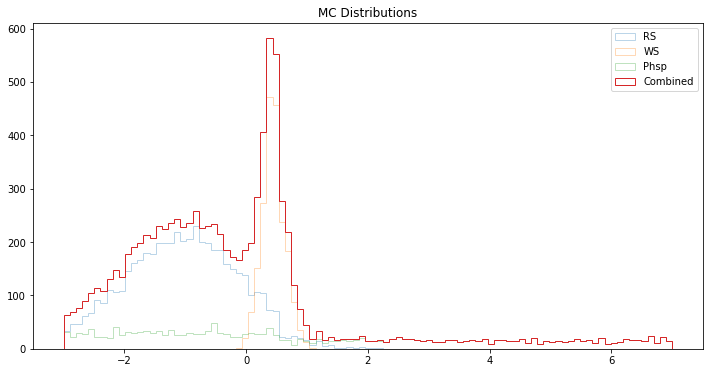

In [25]:
bins = x
kw = {"histtype": "step", "bins": bins}

plt.figure(figsize=(12.0, 6.0))
plt.hist(mc_rs_sample, **kw, alpha=0.3, label="RS")
plt.hist(mc_ws_sample, **kw, alpha=0.3, label="WS")
plt.hist(mc_phsp_sample, **kw, alpha=0.3, label="Phsp")
plt.hist(mc_sample, **kw, label="Combined")
plt.legend()
plt.title("MC Distributions")
plt.show()

Next we need to find the weights $\mathcal{I}_i$ describing the combined model:

In [26]:
I_rs, I_ws = 0.0, 0.0

for p in mc_rs_sample:
    I_rs += 1 / A_rs(p)
for p in mc_ws_sample:
    I_ws += 1 / A_ws(p)
    
# Scale the weights to something more sensible
scale_factor = I_rs + I_ws
I_rs /= scale_factor
I_ws /= scale_factor

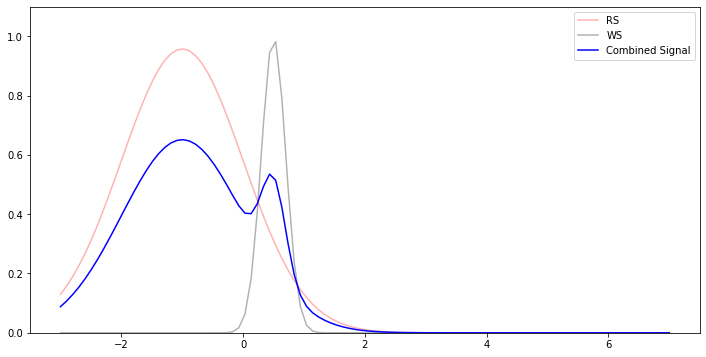

In [27]:
def p_signal(x):
    return I_rs * A_rs(x) + I_ws * A_ws(x)

plt.figure(figsize=(12.0, 6.0))
plt.plot(x, [A_rs(i) for i in x], "r", label="RS", alpha=0.3)
plt.plot(x, [A_ws(i) for i in x], "k", label="WS", alpha=0.3)

plt.plot(x, [p_signal(i) for i in x], "b", label="Combined Signal")
plt.gca().set_ylim((0.0, 1.1))
plt.legend()

plt.show()

We can then construct the model PDF. This, when multiplied by the efficiency, should also describe the MC sample.

In [32]:
I_signal, I_phsp = 0.0, 0.0

for p in np.concatenate((mc_rs_sample, mc_ws_sample)):
    I_signal += 1 / p_signal(p)
for p in mc_phsp_sample:
    I_phsp += 1 / A_phsp(p)
    
# Scale the weights to something more sensible
scale_factor = I_phsp + I_signal
I_signal /= scale_factor
I_phsp /= scale_factor

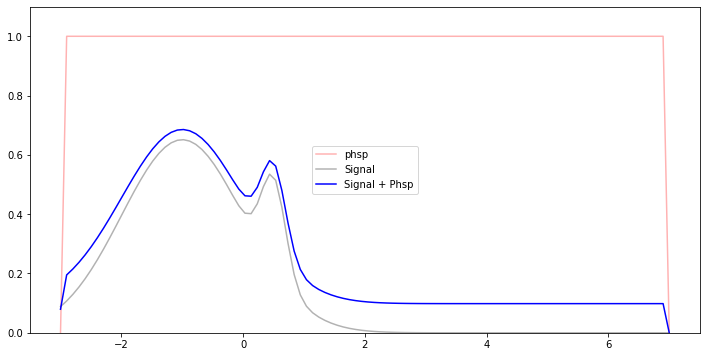

In [33]:
def p_combined(x):
    return I_signal * p_signal(x) + I_phsp * A_phsp(x)

plt.figure(figsize=(12.0, 6.0))
plt.plot(x, [A_phsp(i) for i in x], "r", label="phsp", alpha=0.3)
plt.plot(x, [p_signal(i) for i in x], "k", label="Signal", alpha=0.3)

plt.plot(x, [p_combined(i) for i in x], "b", label="Signal + Phsp")
plt.gca().set_ylim((0.0, 1.1))
plt.legend()

plt.show()

It looks like our combined PDF broadly does what we expected.

Now we just need to take a sample from the Model PDF, compare it to our combined MC samples and we should recover the correct efficiency.

In [34]:
# Take a sample from the combined PDF
combined_sample = sample(N_model, p_combined)

100%|██████████| 4000/4000 [00:02<00:00, 1410.91it/s]


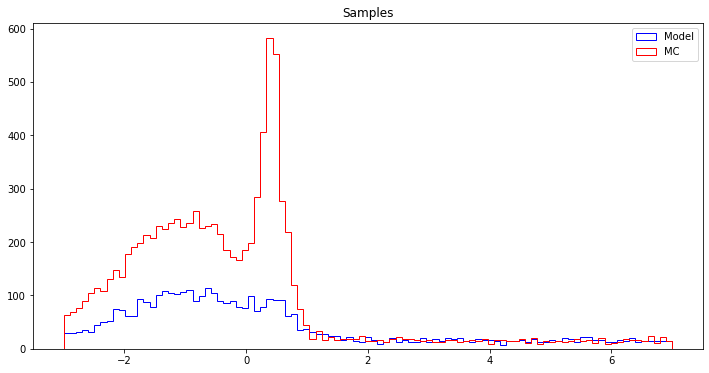

In [35]:
fig = plt.figure(figsize=(12.0, 6.0))

model_hist, _, _ = plt.hist(combined_sample, **kw, label="Model", color="b")
mc_hist, _, _ = plt.hist(mc_sample, **kw, label="MC", color="r")
plt.title("Samples")
plt.legend()

plt.show()

In [36]:
bin_centres = (bins[1:] + bins[:-1]) / 2
hist_ratio = mc_hist / model_hist
ideal_efficiency = [e(x) for x in bin_centres]

1.0370370370370368


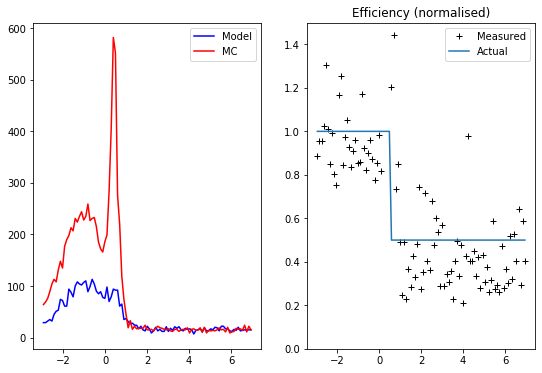

In [38]:
# scale the histogram ratio
# Scale the mean efficiency to 0.675, since that's right
scale_factor = np.mean(hist_ratio) / 0.675
hist_ratio /= scale_factor
print(scale_factor)

fig, ax = plt.subplots(1, 2, figsize=(9, 6))

ax[0].plot(bin_centres, model_hist, "b", label="Model")
ax[0].plot(bin_centres, mc_hist, "r", label="MC")
ax[0].legend()


ax[1].plot(bin_centres, hist_ratio, "k+", label="Measured")
ax[1].plot(bin_centres, ideal_efficiency, label="Actual")
ax[1].set_title("Efficiency (normalised)")
ax[1].set_ylim((0.0, 1.5))
ax[1].legend()
plt.show()